# DWI Workshop - Connectivity

Once you have a tractogram with your candidate streamlines there are then different ways to analyze your tractogram. One of the most common and popular currently is to perform connectivity analysis. 


## What is a Graph? 

A graph is a collection of nodes and edges. A comprehensive set of all pairwise connections in the brain defines the topology of a brain network providing a connectome. Graphs can be directed or undirected, and weighted or binary. In terms of structural connectivity (SC) a graph can be visualized as a connectivity or adjacency matrix. A connectivity matrix is an NxN matrix, where each node represents a region of interest corresponding to a label from an atlas. 

## How to define nodes? 

Nodes are defined typically from a brain parcellation of anatomical MRI data (e.g., freesurfer - DKT, Destrieux, Glasser). These will define the rows and columns of your connectivity matrix. Topological characteristics (graph theory measures) are dependent on the choice of parcellation scheme and may influence group differences. There is no consensus as to which brain parcellation scheme is optimal. Further, it is suggested that parcellations be filtered prior to connectome generation. For instance it would be incorrect to include labels corresponding to white matter or CSF. 

## How to define edges? 

The edge is what we are defining as connectivity, what connects two nodes. This can be the number, length, or volume of streamlines between two nodes. Or, it can be defined by the mean values of a diffusion metrics along the path of the streamlines/fiber bundles between two nodes. This can be the ADC, FA, MD, RD, ICVF, ODI, NDI (NODDI metrics), the AFC, g-ratio or even T1 and T2 values. 

## Streamline to Node Assignment 


<p align='center'>
  <img src ="images/DefiningNodes.jpg" alt='fodf' width=400/>
</p>


In [3]:
# Generation of a connectivity matrix 

# This can be done using scilpy or mrtrix3. 

# We have provided a script for you based on a scilpy script. This script is specfific for the DKT atlas, 
# aparc+aseg.mgz, obtained after running freesurfer. You will need to update the labels in the script accordingly 
# based on what atlas you use, and the corresponding labels obtained from a lookup table. 


bash runConnectivy.sh 

This will ensure labels are isotropic and cleaned, and also update the headers with the appropriate information
Then it will call scil_compute_connectivity.py to compute the SC matrix based on the fiber count. 

* Clean Labels. 
* Generate Connectivity Matrix 
* Post process 

in addition one can run [tck2connectome](https://mrtrix.readthedocs.io/en/dev/reference/commands/tck2connectome.html) in mrtrix after ensuring the labels are isotropic and cleaned, meaning CSF and WM labels are removed. This will allow one to then create an SC matrix weighted by any metric, such as FA, MD, etc...
 
However, while interesting a caveat is that these may make subsequent interpretation of some GT metrics less interpretable. For instance calculating the distance between two ROIs or nodes, is not as interpretable when based off of FA compared to a conventional euclidian distance. 



In [ ]:
# In mrtrix 

#tck2connectome tracks_in connectome_out

# to generate where the value of connectivity is mean FA 

#tcksample tracks.tck FA.mif mean_FA_per_streamline.csv -stat_tck mean
#tck2connectome tracks.tck nodes.mif mean_FA_connectome.csv -scale_file mean_FA_per_streamline.csv -stat_edge mean


In [7]:
%cd /Users/afinkelstein/Documents/Projects/Data/Connectivity 

/Users/afinkelstein/Documents/Projects/Data/Connectivity


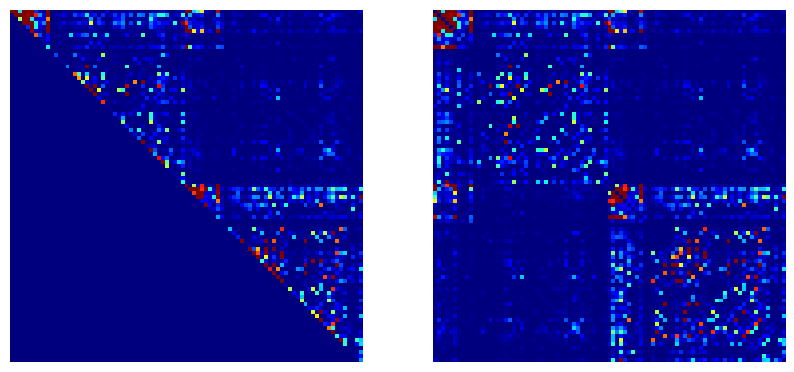

In [37]:
import numpy as np
import matplotlib.pyplot as plt 

tmp_mat = np.load('final_matrix.npy')
tmp_mat2 =np.zeros_like(tmp_mat)
for i in range(tmp_mat.shape[0]):
    for j in range(tmp_mat.shape[1]):
        if i == j: 
            tmp_mat2[i,j] =0 # Pre-requistie for graph theory. Self connections are set to zero. 
        elif i < j:
            tmp_mat2[j,i] = tmp_mat[i,j] # Matrix is symmetric about the diagonal. 
            tmp_mat2[i,j] = tmp_mat[i,j]

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(tmp_mat,cmap='jet'), plt.axis('off'), plt.clim(0,200),
plt.subplot(122), plt.imshow(tmp_mat2, cmap='jet'), plt.axis('off')
plt.clim(0,200)
plt.show()

In [39]:
%cd /Users/afinkelstein/Documents/Projects/Data
!mrview labels_cleaned_connectivity.nii.gz -connectome.init labels_cleaned_connectivity.nii.gz -connectome.load connectome2.csv

/Users/afinkelstein/Documents/Projects/Data


#### We can also view the SC matrix as a 3D-representation, where the spheres represent the nodes, and the lines represent the edges.

<table><tr>
    <td> <img src ="images/3DConnectivity2.png" alt='fodf' width=500/> </td>
    <td><img src ="images/3DConnectivity3.png" alt='fodf' width=500/></td>
</tr></table>


## [Graph Theory](https://reader.elsevier.com/reader/sd/pii/S105381190901074X?token=792EC80EB39F420CF70658E7BC326DC4731529F0F21C65D91E6684CA56096FC80A7EE205BDFC12671A9283D15042BD0C&originRegion=us-east-1&originCreation=20230309233321)

For an further or more technical explanation of the different graph theory metrics and functions please see the following [website](https://sites.google.com/site/bctnet/). 

<p align='center'>
  <img src ="images/GraphMeasures.png" alt='fodf' width=500/>
</p>

Briefly:
* Matrices must be square (NxN), rows and columns should represent network nodes, and entries represent network links (FA, fiber count, etc.). 
* Matrices should be > 20.
* Matrices may be binary or weighted, directed or undirected. 
* Matrices should not have self-connections (diagonal should be set to 0). 
* Matrices should not contain negative weights

Further matrices may be binary or weighted, and dense or sparse. Binary matrices only consider whether or not there are streamlines between two ROIs. However, this may obscure some of the subtelty or heterogeneity especially in diseases such as Alzheimer's where connectivity may be altered not due to the absence of streamlines, but due their density or integrity. However, early graph theory measures were based on binary matrices, but today these are not as biologically plausible as weighted matrices. Moreover with the advent of methods such as ACT and microstructure informed tractogram filtering (e.g. SIFT, COMMIT) fiber density, and hence weighted matrices are more biologically plausible with fewer false positive streamlines. 

With regard to density: Various methods, such as SIFT and ACT aim to reduce the number of spurious streamlines. However, several proponents argue that is still necessary to "filter" streamlines or weak connections in the connectivity matrix by thresholding based on some value. Moreover, some of the graph theory metrics, such as the clustering coefficient, rely on sparse matrices. However, thresholding of matrices and determining the optimal level of sparsity is not well established, and remains arbitrary. 

For both of these considerations it is important to note that graph theory measures themselves may vary based on post-processing choices, such as density. 

<p align='center'>
  <img src ="images/SparsityEffect.gif" alt='fodf' width=500/>
</p>

Effect of sparsity in group comparisons - https://ieeexplore.ieee.org/document/9871258

So this is even another way of visualizing your data, or defining your optimal sparsity value, with which to calculate other GT metrics. 
